c:\Users\user\Documents\dev\qiskit\venv\Lib\site-packages\qiskit\utils\classtools.py:112: RuntimeWarning: Cregbundle set to False since an instruction needs to refer to individual classical wire
  retval = method(*args, **kwargs)


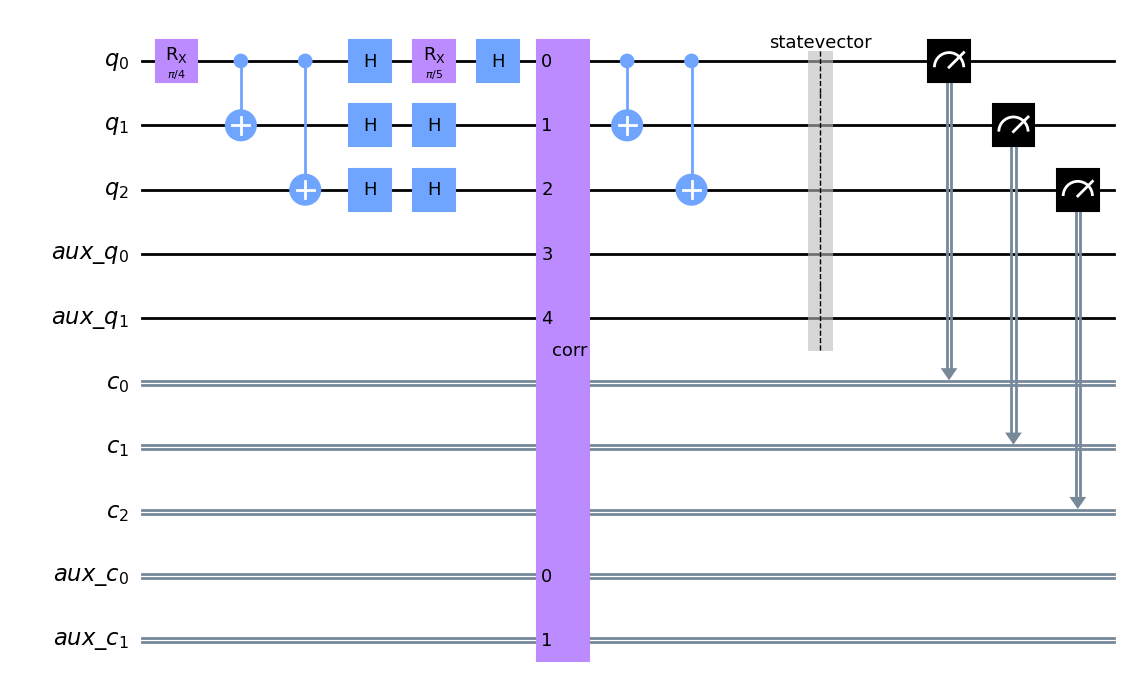

In [116]:
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from math import pi

def corr_circ():
    q = QuantumRegister(3, 'q')
    aux_q = QuantumRegister(2, 'aux_q')
    aux_c = ClassicalRegister(2, 'aux_c')
    qc = QuantumCircuit(q, aux_q, aux_c, name='corr')

    qc.cx(q[0], aux_q[0])
    qc.cx(q[1], aux_q[0])
    qc.cx(q[1], aux_q[1])
    qc.cx(q[2], aux_q[1])

    qc.ccx(aux_q[0], aux_q[1], q[1])
    qc.ccx(aux_q[0], aux_q[1], q[0], ctrl_state='01')
    qc.ccx(aux_q[0], aux_q[1], q[2], ctrl_state='10')

    # measurement deferred
    qc.measure(aux_q, aux_c)
    qc.reset(aux_q)
    qc.measure(aux_q, aux_c)

    return qc

PHASE_FLIP_CORRECTION = 1

q = QuantumRegister(3, 'q')
aux_q = QuantumRegister(2, 'aux_q')
c = ClassicalRegister(3, 'c')
aux_c = ClassicalRegister(2, 'aux_c')
qc = QuantumCircuit(q, aux_q, c, aux_c)

# initialise q[0]
qc.rx(pi/4, q[0])

# circuit starts

# entangle the bits
qc.cx(q[0], q[1])
qc.cx(q[0], q[2])

if PHASE_FLIP_CORRECTION:
    for qubit in q:
        qc.h(qubit)

# bit flip through noisy channel
qc.rx(pi/5, q[0])
# phase flip through noisy channel
# qc.z(q[0])

if PHASE_FLIP_CORRECTION:
    for qubit in q:
        qc.h(qubit)

qc.append(corr_circ(), q[:] + aux_q[:], aux_c)

# unentangle the bits
qc.cx(q[0], q[1])
qc.cx(q[0], q[2])

qc.save_statevector()

qc.measure(q, c)
qc.draw('mpl')





In [117]:
simulator = AerSimulator()
compiled_circuit = transpile(qc, simulator)

job = simulator.run(compiled_circuit, shots=1000)

result = job.result()
counts = result.get_counts(compiled_circuit)
print("\nCounts:", counts)
print("Statevector:", result.get_statevector(compiled_circuit))

# without disturbance
# 0: 9.23879533e-01-4.35725672e-33j
# 1: 2.34326020e-17-3.82683432e-01j
# with phase flip
# 9.23879533e-01-4.35725672e-33j
# -7.02978061e-17+3.82683432e-01j


Counts: {'00 000': 844, '00 001': 156}
Statevector: Statevector([ 0.87866165-0.28549448j,  0.11825568-0.36395357j,
              0.        +0.j        ,  0.        +0.j        ,
              0.        +0.j        ,  0.        +0.j        ,
              0.        +0.j        ,  0.        +0.j        ,
              0.        +0.j        ,  0.        +0.j        ,
              0.        +0.j        ,  0.        +0.j        ,
              0.        +0.j        ,  0.        +0.j        ,
              0.        +0.j        ,  0.        +0.j        ,
              0.        +0.j        ,  0.        +0.j        ,
              0.        +0.j        ,  0.        +0.j        ,
              0.        +0.j        ,  0.        +0.j        ,
              0.        +0.j        ,  0.        +0.j        ,
             -0.        +0.j        , -0.        +0.j        ,
              0.        +0.j        ,  0.        +0.j        ,
             -0.        +0.j        , -0.        +0.j        ,
  

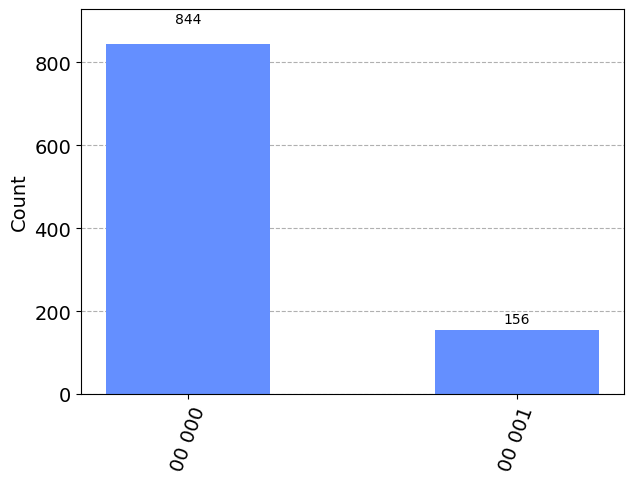

In [118]:
plot_histogram(counts)